In [1]:
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import torch

In [2]:
model_name = "google-bert/bert-large-uncased-whole-word-masking-finetuned-squad"

In [3]:
model = BertForQuestionAnswering.from_pretrained(model_name)

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [5]:
# EMBEDDINGS

In [6]:
# example question and text containing the answer
question = "When was the first light bulb created?"
answer_document = "The first practical lightbulb was created by Thomas Edison in 1879."

In [7]:
encoding = tokenizer.encode_plus(text=question, text_pair=answer_document)

In [8]:
print(encoding)

{'input_ids': [101, 2043, 2001, 1996, 2034, 2422, 20581, 2580, 1029, 102, 1996, 2034, 6742, 2422, 8569, 20850, 2001, 2580, 2011, 2726, 17046, 1999, 7449, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
inputs = encoding['input_ids']
sentence_embedding = encoding['token_type_ids']
tokens = tokenizer.convert_ids_to_tokens(inputs)

In [10]:
tokenizer.decode(101)

'[CLS]'

In [11]:
tokenizer.decode(102)

'[SEP]'

In [12]:
output = model(input_ids = torch.tensor([inputs]), token_type_ids = torch.tensor([sentence_embedding]))

In [13]:
#MODEL OUTPUT

In [14]:
start_index = torch.argmax(output.start_logits)
end_index = torch.argmax(output.end_logits)

print(start_index)
print(end_index)

tensor(22)
tensor(22)


In [15]:
answer = ' '.join(tokens[start_index:end_index+1])
print(answer)

1879


In [16]:
# VISUALIZING THE DIFFERENT TOKENS AND PROBABILITY OF BEING THE START AND OR END TOKEN

In [17]:
import matplotlib as plt
import seaborn as sns

In [18]:
s_scores = output.start_logits.detach().numpy().flatten()
e_scores = output.end_logits.detach().numpy().flatten()

In [19]:
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

C:\Users\Nkosi\AppData\Local\Temp\ipykernel_26844\1538046351.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


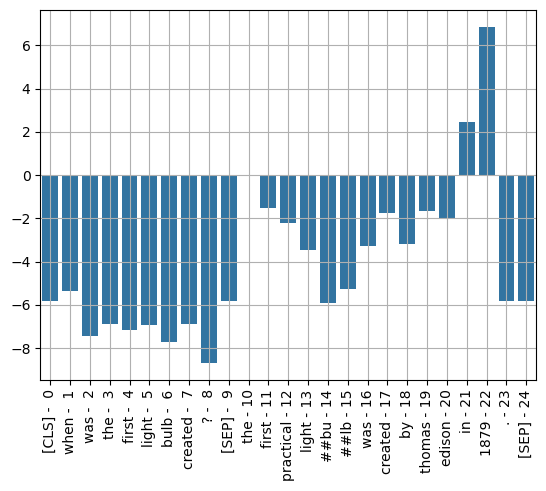

In [20]:
ax = sns.barplot(x=token_labels, y=s_scores)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)

C:\Users\Nkosi\AppData\Local\Temp\ipykernel_26844\365763533.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


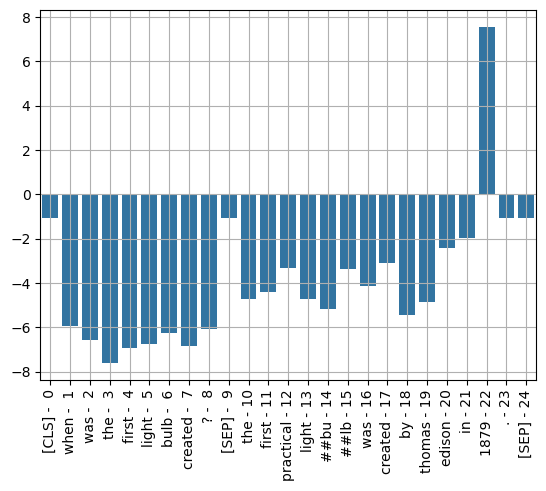

In [21]:
ax = sns.barplot(x=token_labels, y=e_scores)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)

In [22]:
# QUESTION ANSWERING

In [23]:
khululeka_airways_context = """Khululeka Airways is a leading global airline that prides itself on delivering exceptional service and unforgettable travel experiences. Established in 2005, we have grown from a small regional carrier to an internationally recognized airline known for our commitment to comfort, safety, and reliability. At Khululeka, we understand that air travel is not just about getting from point A to point B—it’s about the journey. Whether you're flying for business or leisure, we aim to make every aspect of your experience as smooth and enjoyable as possible. From the moment you book your flight to the time you land at your destination, our team is dedicated to providing top-tier service with a personal touch.

Khululeka’s fleet consists of state-of-the-art aircraft designed to provide comfort, efficiency, and safety. Our planes are equipped with the latest in-flight entertainment systems, Wi-Fi access, and comfortable seating to ensure a relaxed journey. We offer both short-haul and long-haul flights, serving major cities and vacation destinations across the globe. Khululeka Airways is proud to operate a state-of-the-art fleet of aircraft that prioritize safety, passenger comfort, and environmental sustainability. Our modern fleet includes a mix of cutting-edge long-haul and short-haul aircraft, featuring the latest technological innovations to ensure an exceptional flying experience boasting 10 Boeing 787 Dreamliners, 5 Boeing 737 MAXes, 10 Embraer E190-E2’s, and 10 Airbus A220s."""

print(khululeka_airways_context)

Khululeka Airways is a leading global airline that prides itself on delivering exceptional service and unforgettable travel experiences. Established in 2005, we have grown from a small regional carrier to an internationally recognized airline known for our commitment to comfort, safety, and reliability. At Khululeka, we understand that air travel is not just about getting from point A to point B—it’s about the journey. Whether you're flying for business or leisure, we aim to make every aspect of your experience as smooth and enjoyable as possible. From the moment you book your flight to the time you land at your destination, our team is dedicated to providing top-tier service with a personal touch.

Khululeka’s fleet consists of state-of-the-art aircraft designed to provide comfort, efficiency, and safety. Our planes are equipped with the latest in-flight entertainment systems, Wi-Fi access, and comfortable seating to ensure a relaxed journey. We offer both short-haul and long-haul fli

In [24]:
def faq_bot(question):
    context = khululeka_airways_context
    input_ids = tokenizer.encode(question, context)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    sep_idx = input_ids.index(tokenizer.sep_token_id)
    num_seg_a = sep_idx + 1
    num_seg_b = len(input_ids) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = ' '.join(tokens[answer_start:answer_end+1])
    else:
        print("I don’t know how to answer this question, can you ask another one?")

    corrected_answer = ''
    for word in answer.split():
        if word[0:2] == '##':
            corrected_answer += word[2:]
        else:
            corrected_answer += ' ' + word

    return corrected_answer

In [25]:
faq_bot("When was khululeka airways established?")

' 2005'

In [26]:
faq_bot("What make of aircrafts are available?")

' cutting - edge long - haul and short - haul aircraft , featuring the latest technological innovations to ensure an exceptional flying experience boasting 10 boeing 787 dreamliners , 5 boeing 737 maxes , 10 embraer e190 - e2 ’ s , and 10 airbus a220s'

In [27]:
faq_bot("Where does khululeka airways operate?")

' major cities and vacation destinations across the globe'